# Step 0: Getting performance data

To use IOHinspector, your performance data should be in the IOHexperimenter format. The easiest way to achieve this is by using IOHexperimenter directly to run your benchmarks. 

In a future release, we will include support for reading additional data formats, including COCO and Nevergrad, as well as support for custom loading of csv-files. 

Throughout this notebook, we will use a small artificial dataset of 2 algorithms run on 2 BBOB functions. This data is included with the 'IOHinspector' package, and can also be found on the IOHdata repository. 

For completeness, we include the code used to generate this dataset here as well. For more information on running experiments with IOHexperimenter, see [this tutorial](https://github.com/IOHprofiler/IOHexperimenter/blob/master/example/tutorial.ipynb)

In [1]:
import ioh
import numpy as np
import os

class HillClimber():
    'Simple hill climber algorithm'
    def __init__(self, n: int, sigma: float = 1.0, rng = None):
        self.n: int = n
        self.sigma: float = sigma
        if rng:
            self.rng = rng
        else:
            self.rng = np.random.default_rng()
            
    def __call__(self, problem: ioh.problem.RealSingleObjective) -> None:
        x = self.rng.uniform(problem.bounds.lb, problem.bounds.ub)
        y = problem(x)
        for _ in range(self.n-1):
            x1 = np.clip(x + self.rng.normal(0, self.sigma, x.shape), problem.bounds.lb, problem.bounds.ub)
            y1 = problem(x1)    
            if y1 < y:
                x = x1
                y = y1

class RandomSearch:
    'Simple random search algorithm'
    def __init__(self, n: int, rng = None):
        self.n: int = n
        if rng:
            self.rng = rng
        else:
            self.rng = np.random.default_rng()

    def __call__(self, problem: ioh.problem.RealSingleObjective) -> None:

        for _ in range(self.n):
            # We can use the problems bounds accessor to get information about the problem bounds
            x = self.rng.uniform(problem.bounds.lb, problem.bounds.ub)
            
            problem(x)    

def run_experiment(algorithm, logger):
    for fid in range(1,3):
        for iid in range(1,16):
            f = ioh.get_problem(fid, iid, 2) 
            f.attach_logger(logger)
            algorithm(f)
            f.reset()

if False: #To run the data collection, set to True
    if not os.path.exists("SO_Data"):
        os.mkdir("SO_Data")
    rng = np.random.default_rng(42)

    logger = ioh.logger.Analyzer(
        root="SO_Data",                  # Store data in the current working directory
        folder_name="HC",       # in a folder named: 'my-experiment'
        algorithm_name="HillClimber",    # meta-data for the algorithm used to generate these results
        store_positions=True               # store x-variables in the logged files
    )

    run_experiment(HillClimber(1000, 1, rng), logger)
    logger = ioh.logger.Analyzer(
        root="SO_Data",                  # Store data in the current working directory
        folder_name="RS",       # in a folder named: 'my-experiment'
        algorithm_name="RandomSearch",    # meta-data for the algorithm used to generate these results
        store_positions=True               # store x-variables in the logged files
    )

    run_experiment(RandomSearch(1000, rng), logger)

# Step 1: Loading Data

The main component of IOHinspector is the DataManager. In essence, this is the object which handles the meta-data of the selected experiments to allow for filtering and later loading of only the required performance files. 

In [2]:
from iohinspector import DataManager

## Initializing the DataManager

To initialize the data manager, we can simply add folders to it.  Note that this works recursively, so we can just add the entire 'SO_Data' folder at once:

In [3]:
manager = DataManager()
manager.add_folder("SO_Data")

With the data loaded, we can verify whether all runs are present by checking the 'overview' attribute of the created manager

In [4]:
manager.overview

data_id,algorithm_name,algorithm_info,suite,function_name,function_id,dimension,instance,run_id,evals,best_y
u64,str,str,str,str,u16,u16,u16,u32,u64,f64
1,"""RandomSearch""","""algorithm_info""","""unknown_suite""","""Ellipsoid""",2,2,1,1,1000,47.150496
2,"""RandomSearch""","""algorithm_info""","""unknown_suite""","""Ellipsoid""",2,2,2,2,1000,41.120049
3,"""RandomSearch""","""algorithm_info""","""unknown_suite""","""Ellipsoid""",2,2,3,3,1000,36.072013
4,"""RandomSearch""","""algorithm_info""","""unknown_suite""","""Ellipsoid""",2,2,4,4,1000,31.407138
5,"""RandomSearch""","""algorithm_info""","""unknown_suite""","""Ellipsoid""",2,2,5,5,1000,25.438597
…,…,…,…,…,…,…,…,…,…,…
56,"""HillClimber""","""algorithm_info""","""unknown_suite""","""Sphere""",1,2,11,11,1000,0.000205
57,"""HillClimber""","""algorithm_info""","""unknown_suite""","""Sphere""",1,2,12,12,1000,0.000198
58,"""HillClimber""","""algorithm_info""","""unknown_suite""","""Sphere""",1,2,13,13,1000,0.001264


To get some summary information, such as the loaded algorithms or functions, we can use the corresponding attributes of the datamanager:

In [5]:
manager.algorithms, manager.functions

((Algorithm(name='RandomSearch', info='algorithm_info'),
  Algorithm(name='RandomSearch', info='algorithm_info'),
  Algorithm(name='HillClimber', info='algorithm_info'),
  Algorithm(name='HillClimber', info='algorithm_info')),
 (Function(id=2, name='Ellipsoid', maximization=False),
  Function(id=1, name='Sphere', maximization=False),
  Function(id=2, name='Ellipsoid', maximization=False),
  Function(id=1, name='Sphere', maximization=False)))

## Filtering Data

A data manager object also allows for sub-selection of data. This can be done throught the 'select' function, where any set of function ids, algorithms etc. can be provided.
This selection also which works on the 'data_id' column from the overview, which enables more complex selection rules by utilizing the overview as a polars dataframe. 

In [6]:
#selecting on function id
manager_sub = manager.select(function_ids=[1])

In [7]:
manager_sub.overview

data_id,algorithm_name,algorithm_info,suite,function_name,function_id,dimension,instance,run_id,evals,best_y
u64,str,str,str,str,u16,u16,u16,u32,u64,f64
16,"""RandomSearch""","""algorithm_info""","""unknown_suite""","""Sphere""",1,2,1,1,1000,0.080698
17,"""RandomSearch""","""algorithm_info""","""unknown_suite""","""Sphere""",1,2,2,2,1000,0.068596
18,"""RandomSearch""","""algorithm_info""","""unknown_suite""","""Sphere""",1,2,3,3,1000,0.120392
19,"""RandomSearch""","""algorithm_info""","""unknown_suite""","""Sphere""",1,2,4,4,1000,0.010721
20,"""RandomSearch""","""algorithm_info""","""unknown_suite""","""Sphere""",1,2,5,5,1000,0.003647
…,…,…,…,…,…,…,…,…,…,…
56,"""HillClimber""","""algorithm_info""","""unknown_suite""","""Sphere""",1,2,11,11,1000,0.000205
57,"""HillClimber""","""algorithm_info""","""unknown_suite""","""Sphere""",1,2,12,12,1000,0.000198
58,"""HillClimber""","""algorithm_info""","""unknown_suite""","""Sphere""",1,2,13,13,1000,0.001264


In [8]:
import polars as pl

In [9]:
#selecting based on arbitrary query on overview dataframe
ids = manager.overview.filter((pl.col('function_name') == "Sphere") & (pl.col('instance') == 3))['data_id']
manager_sub2 = manager.select(ids)

In [10]:
manager_sub2.overview

data_id,algorithm_name,algorithm_info,suite,function_name,function_id,dimension,instance,run_id,evals,best_y
u64,str,str,str,str,u16,u16,u16,u32,u64,f64
18,"""RandomSearch""","""algorithm_info""","""unknown_suite""","""Sphere""",1,2,3,3,1000,0.120392
48,"""HillClimber""","""algorithm_info""","""unknown_suite""","""Sphere""",1,2,3,3,1000,0.000441


## Loading in Performance Data

With a given data manager, we have the option to load all corresponding performance data into memory, using the 'load' function. This function has the option to make the performance data monotonic (which can be useful when e.g. all evaluations are logged while you care about best-so-far performance statistics), whether to include the meta-data (e.g. data about the algorithms and problems). For a more fine-grained control of which meta-data to include, the include-columns argument can be used to determine which exact columns (names as in the datamanager's overview) should be included.  

In [11]:
df = manager.load(True, True)
df

data_id,algorithm_name,algorithm_info,suite,function_name,function_id,dimension,instance,run_id,evals,best_y,evaluations,raw_y,x0,x1
u64,str,str,str,str,u16,u16,u16,u32,u64,f64,u64,f64,f64,f64
1,"""RandomSearch""","""algorithm_info""","""unknown_suite""","""Ellipsoid""",2,2,1,1,1000,47.150496,1,8.2124e6,-0.530698,-2.494956
1,"""RandomSearch""","""algorithm_info""","""unknown_suite""","""Ellipsoid""",2,2,1,1,1000,47.150496,5,3.5690e6,0.781847,-1.365995
1,"""RandomSearch""","""algorithm_info""","""unknown_suite""","""Ellipsoid""",2,2,1,1,1000,47.150496,9,143888.777772,1.231167,0.847804
1,"""RandomSearch""","""algorithm_info""","""unknown_suite""","""Ellipsoid""",2,2,1,1,1000,47.150496,24,69448.892009,-1.347449,0.709334
1,"""RandomSearch""","""algorithm_info""","""unknown_suite""","""Ellipsoid""",2,2,1,1,1000,47.150496,102,27086.700878,-4.78153,0.293066
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
60,"""HillClimber""","""algorithm_info""","""unknown_suite""","""Sphere""",1,2,15,15,1000,0.004026,25,1.521586,-5.0,-3.120021
60,"""HillClimber""","""algorithm_info""","""unknown_suite""","""Sphere""",1,2,15,15,1000,0.004026,27,0.03135,-3.802689,-2.502291
60,"""HillClimber""","""algorithm_info""","""unknown_suite""","""Sphere""",1,2,15,15,1000,0.004026,32,0.029183,-3.781128,-2.828955


# Step 2: Creating Basic Plots

In [12]:
import iohinspector

IOHinspector provides simple plotting functions to create different types of analysis of your performance data. 

Note: for all plotting functions, the DataFrame (as pandas object) corresponding to the plot is returned as well, so you can verify the data in the figure and easily adapt the visualization if required. Additionally, the functions all have an axis as input argument to allow for easy subplotting and resizing. 

We start by showcasing the default setting for the fixed-target setting (Expected running time)

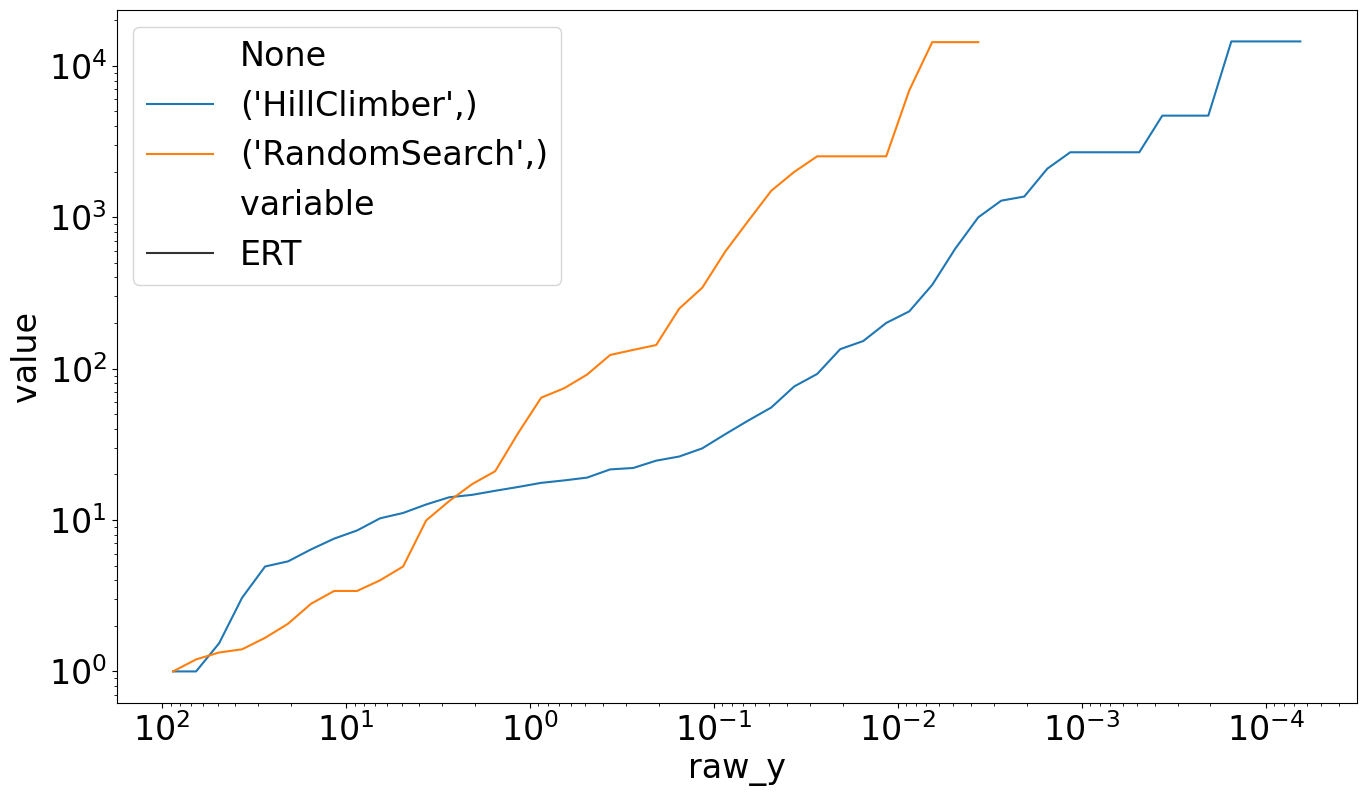

In [13]:
#Note: we filter the data by function ID here. This is equivalent to doing the subselecting before loading the performance data.    
data_singleft = iohinspector.plots.plot_single_function_fixed_target(df.filter(pl.col("function_id") == 1))

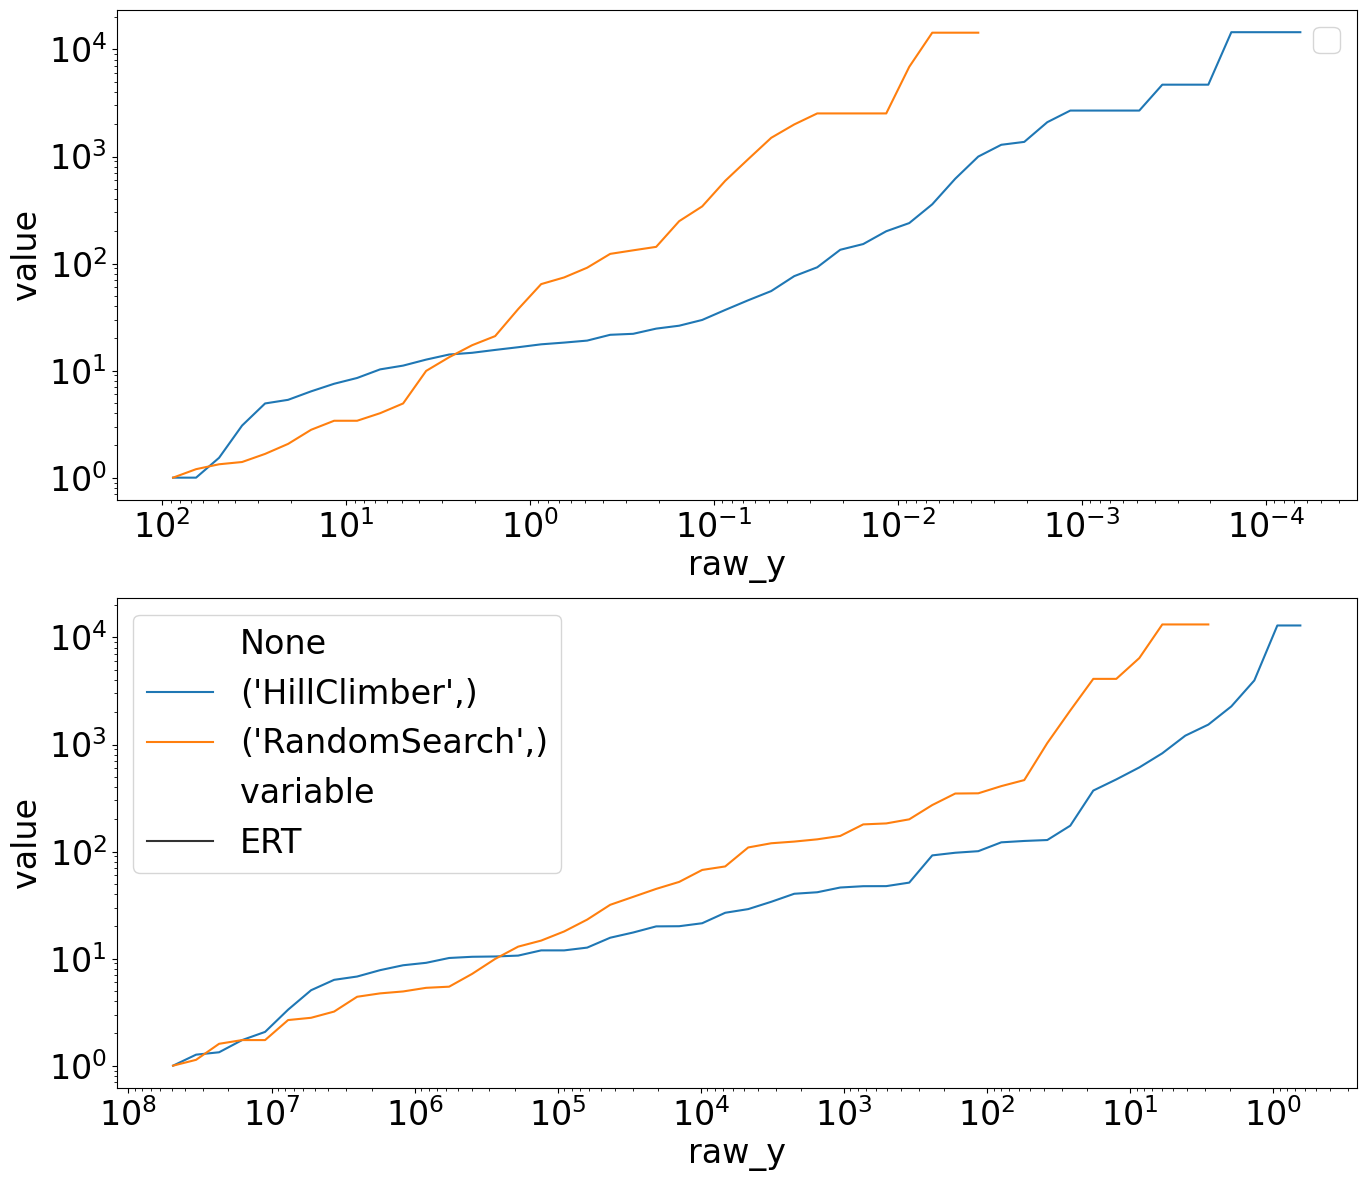

In [14]:
# We can use the same interface to easily make subplots:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,1, sharey=True, figsize=(16,14))
data_singleft1 = iohinspector.plots.plot_single_function_fixed_target(df.filter(pl.col("function_id") == 1), ax=axs[0])
data_singleft2 = iohinspector.plots.plot_single_function_fixed_target(df.filter(pl.col("function_id") == 2), ax=axs[1])
axs[0].legend('') #Disable legend to avoid duplication

The same syntax is used for fixed-budged plots:

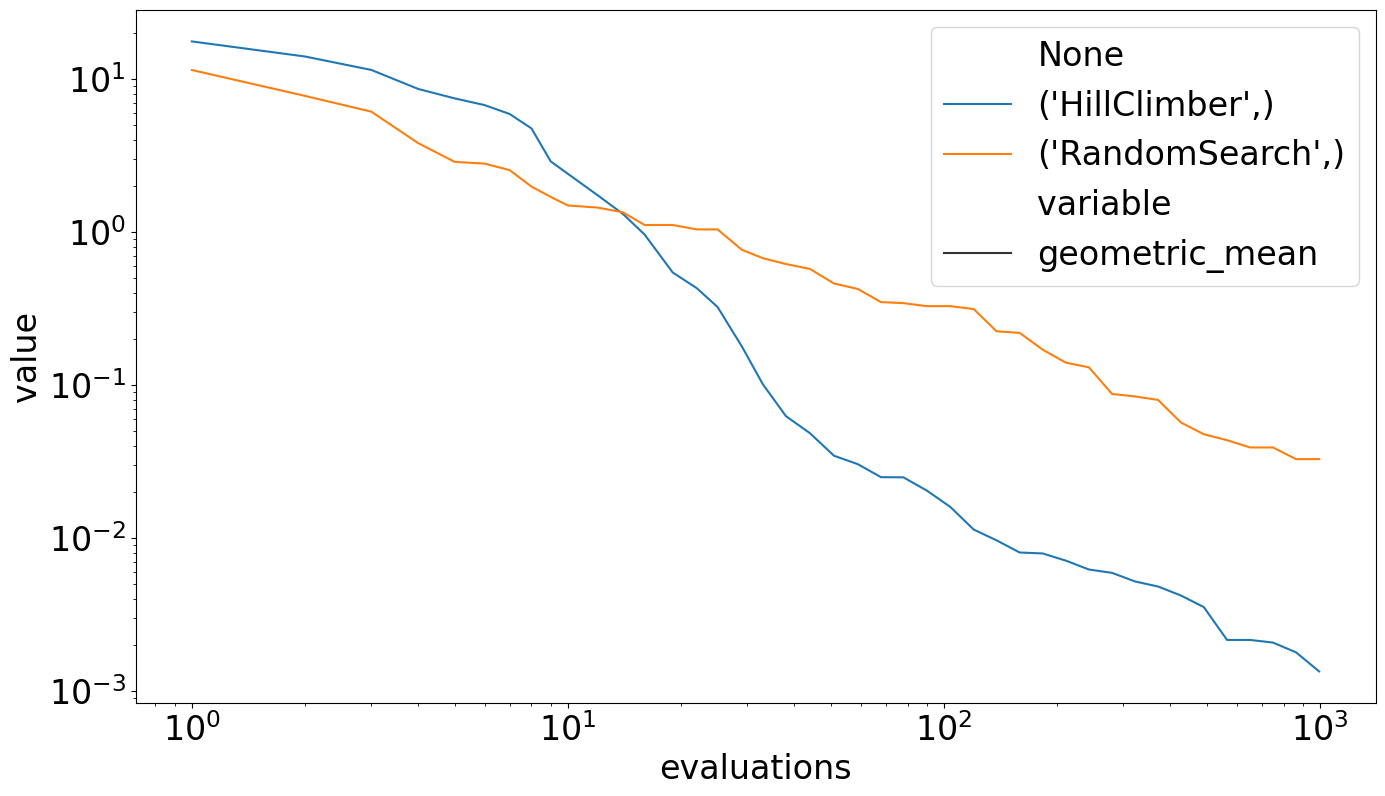

In [15]:
data_singlefb = iohinspector.plots.plot_single_function_fixed_budget(df.filter(pl.col("function_id") == 1))

# Step 3: Empirical Attainment / Cumulative Distribution Functions

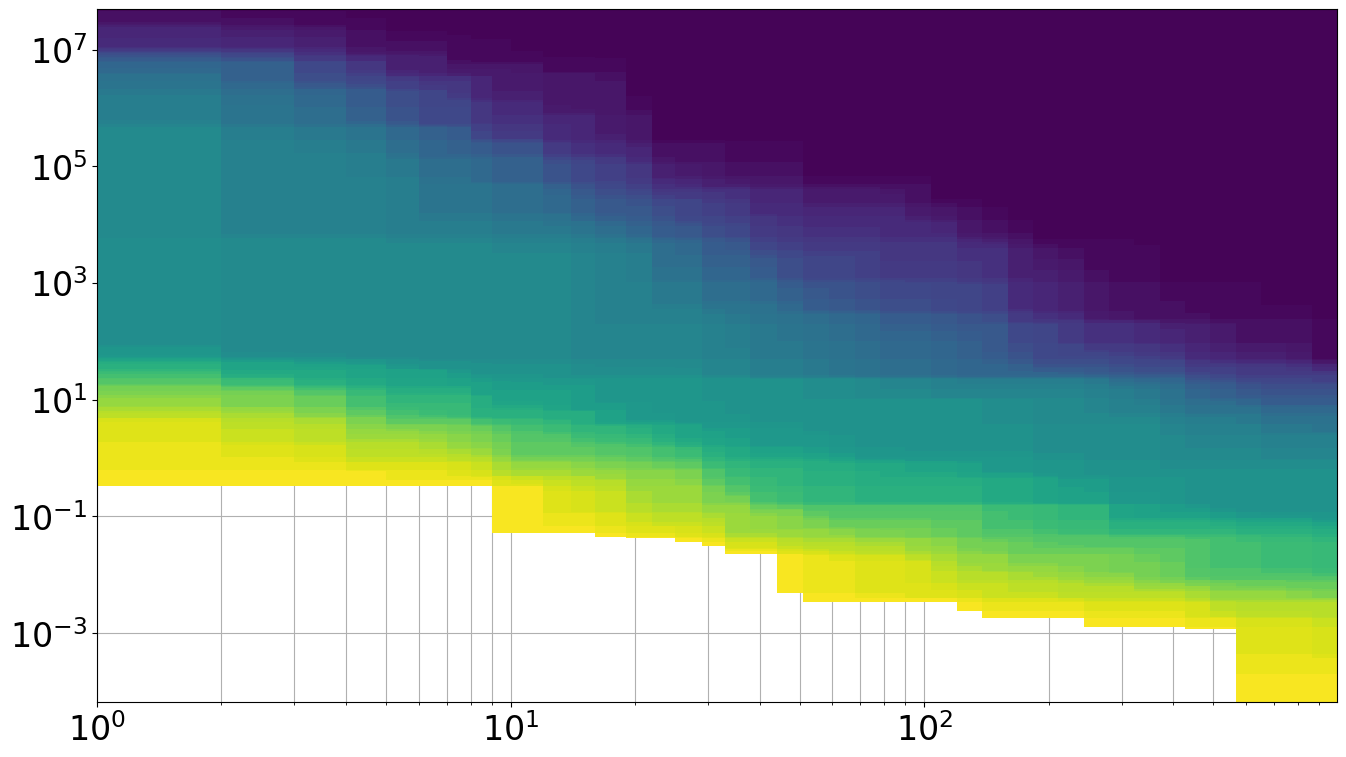

In [ ]:
df_eaf = iohinspector.plots.plot_eaf_single_objective(df)

/home/dinu/miniconda3/envs/iohinspector/lib/python3.10/site-packages/iohinspector/align.py:109: UserWarning: Sortedness of columns cannot be checked when 'by' groups provided
  result_df = x_vals.join_asof(


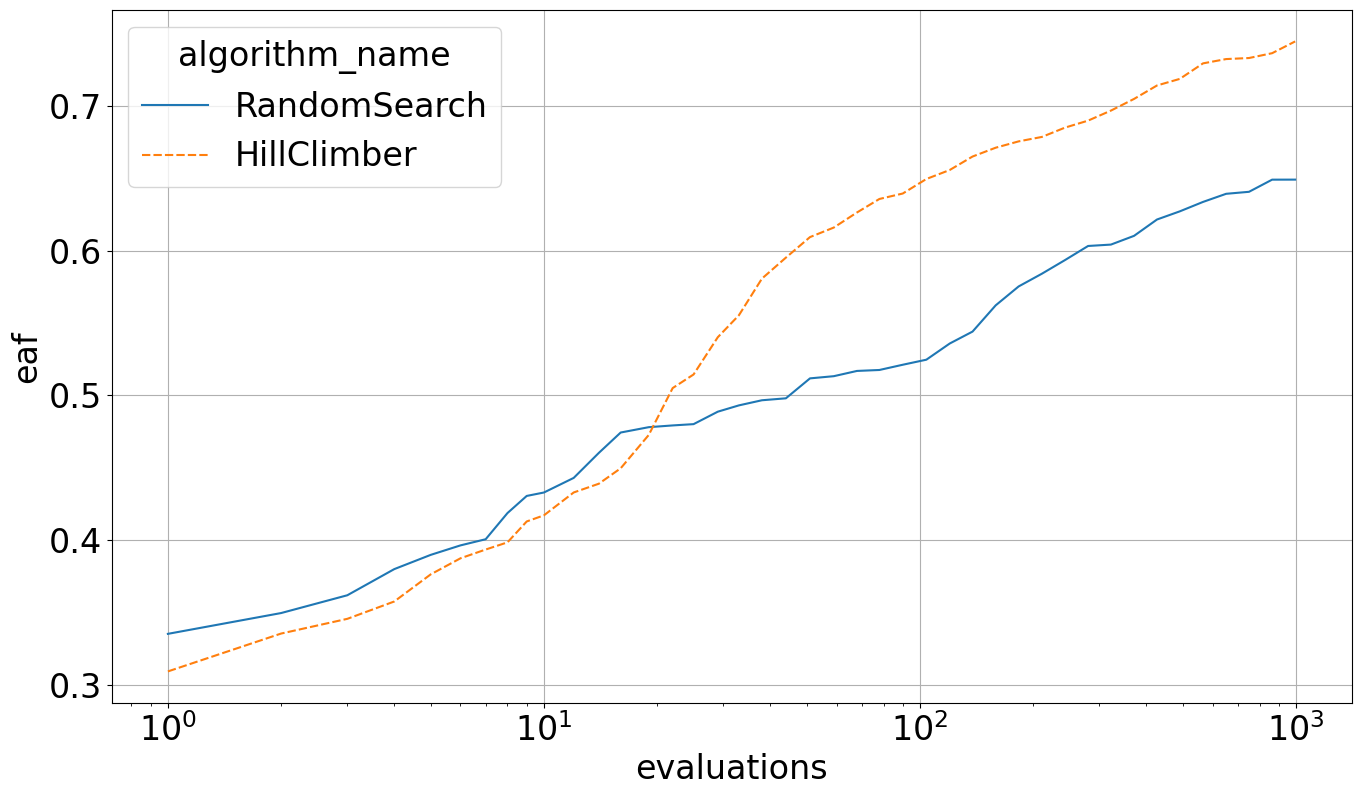

In [17]:
df_ecdf = iohinspector.plots.plot_ecdf(df)

# ELO rating

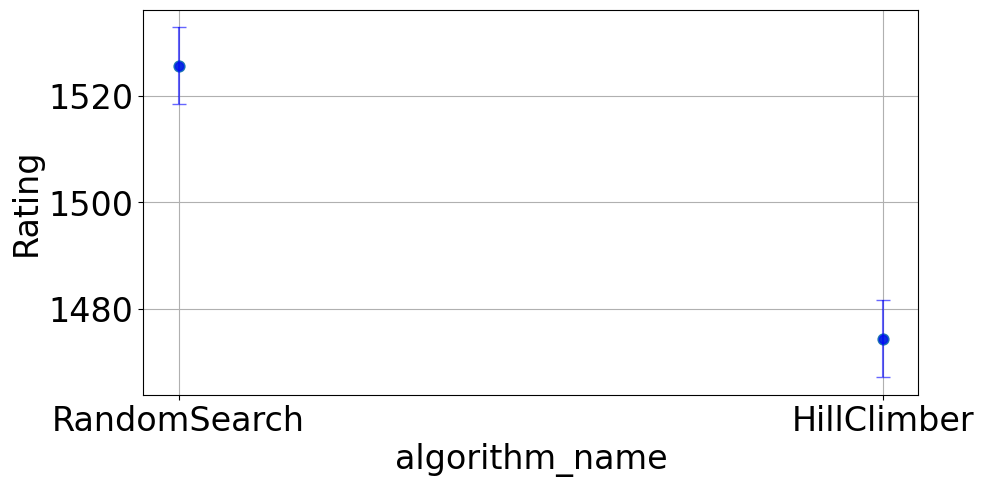

In [ ]:
rating_df = iohinspector.plots.plot_tournament_ranking(df)

# Further analysis
This tutorial is a work-in-progress, more examples will be added in future releases. 